## 1 - Load Dataset

In [1]:
from dataset import ogb_dataset_to_nx_graph

dataset_name = 'ogbn-arxiv'

graph = ogb_dataset_to_nx_graph(dataset_name)

print(f'# of Nodes: {graph.number_of_nodes():_}\n# of Edges: {graph.number_of_edges():_}')

# of Nodes: 169_343
# of Edges: 1_157_799


## 2 - Sample Random Subgraph

In [2]:
import random
from tqdm import tqdm
import numpy as np
from graph import SubgraphHandler

subgraph_size = 100

# Get an initial subgraph node set
#subgraph_nodes = list(np.random.choice(graph.nodes(), size=(subgraph_size), replace=False))
subgraph_nodes = list(np.load('0.151-60k.npy'))

subgraph = SubgraphHandler(
    full_graph = graph, 
    initial_node_set = subgraph_nodes
)

print(f'Initial KS Distance: {subgraph.ks_distance():.5}')

Initial KS Distance: 0.15147


## 3 - Metropolis-Hastings

In [3]:
from logger import RunHistory

logger = RunHistory(subgraph_handler=subgraph,
                    save_interval=100)

In [4]:
num_iters = 5_000

print(f'Saving every {logger.save_interval:_} iterations for a total of {num_iters // logger.save_interval} saves over {num_iters:_} iterations.')

exponent = 80

Saving every 100 iterations for a total of 50 saves over 5_000 iterations.


In [5]:
prev_ks_dist = subgraph.ks_distance()

for i in (pbar := tqdm(range(num_iters))):
    # Randomly pick a node to remove and add to the subgraph
    remove_node = np.random.choice(subgraph.nodes)
    add_node = np.random.choice(subgraph.nodes_not_in_subgraph)

    subgraph.remove(remove_node)
    subgraph.add(add_node)

    # Calculate the new Degree KS Distance
    new_ks_dist = subgraph.ks_distance()

    ratio = prev_ks_dist / new_ks_dist
    if ratio >= 1.0:
        # Accept
        prev_ks_dist = new_ks_dist
        accepted = True
    else:
        score = ratio ** exponent
        prop = random.random()
        if score > prop:
            # Accept
            prev_ks_dist = new_ks_dist
            accepted = True
        else:
            # Reject and revert back
            subgraph.add(remove_node)
            subgraph.remove(add_node)
            accepted = False

    pbar.set_description(f'KS Dist: {prev_ks_dist:.5}')
    logger.log(ratio=ratio, accepted=accepted)

KS Dist: 0.84: 100%|██████████| 5000/5000 [05:03<00:00, 16.50it/s]   


Acceptance Ratio: 55.52%


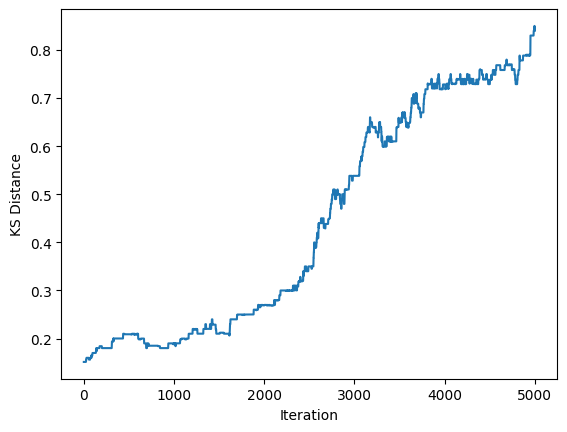

In [6]:
import matplotlib.pyplot as plt

logger.plot_distances()

print(f'Acceptance Ratio: {logger.acceptance_ratio:.2%}')

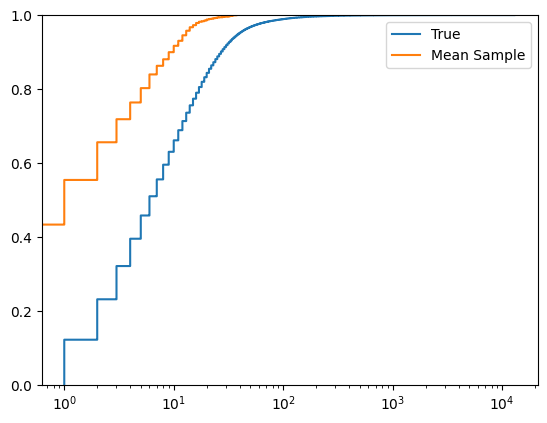

In [7]:
plt.ecdf(subgraph.full_graph_degree_sequence, label='True')

degrees = [list(dict(graph.subgraph(nodes).degree()).values()) for nodes in logger.saved_subgraphs]
all_degrees = []
for d in degrees:
    all_degrees += d

plt.ecdf(all_degrees, label='Mean Sample')

plt.xscale('log')
plt.legend()

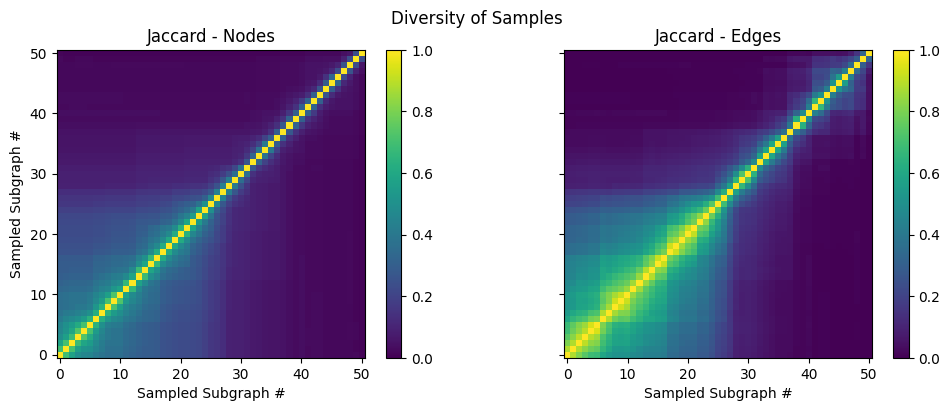

In [8]:
node_sets = [set(nodes) for nodes in logger.saved_subgraphs]
edge_sets = [set(graph.subgraph(nodes).edges()) for nodes in logger.saved_subgraphs]

def jaccard_sim_matrix(set_list: list[set]):
    matrix = np.zeros((len(set_list), len(set_list)))

    for i, set_i in enumerate(set_list):
        for j, set_j in enumerate(set_list):
            if i != j:
                matrix[i,j] = len(set_i.intersection(set_j)) / len(set_i.union(set_j))
            else:
                matrix[i,j] = 1
    return matrix


fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
node_image = axs[0].imshow(jaccard_sim_matrix(node_sets), vmin=0, vmax=1, origin='lower')
fig.colorbar(node_image, ax=axs[0])

axs[0].set_xlabel('Sampled Subgraph #')
axs[0].set_ylabel('Sampled Subgraph #')
axs[0].set_title('Jaccard - Nodes')


edge_image = axs[1].imshow(jaccard_sim_matrix(edge_sets), vmin=0, vmax=1, origin='lower')
fig.colorbar(edge_image, ax=axs[1])

axs[1].set_xlabel('Sampled Subgraph #')
#axs[1].set_ylabel('Sampled Subgraph #')
axs[1].set_title('Jaccard - Edges')

fig.suptitle('Diversity of Samples')

print()

In [9]:
# Add degree distribution PDF calc and viewing
# Same for easy CDF viewing
# Think about and possibly implement KL Divergence

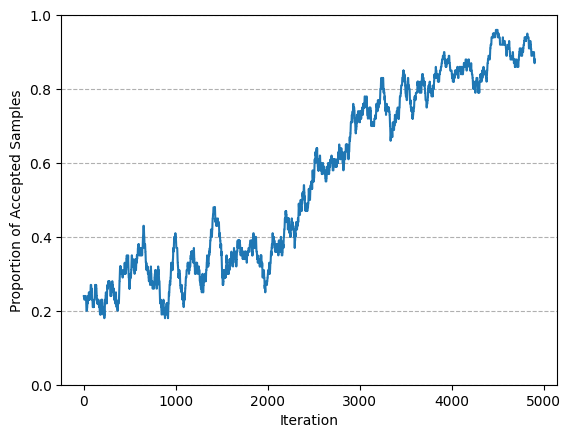

In [10]:
fig, ax = plt.subplots(1,1)

ax.plot(np.convolve(logger.accept_rejects, np.ones(100,) / 100, mode='valid'))

ax.set_xlabel('Iteration')
ax.set_ylabel('Proportion of Accepted Samples')
ax.set_ylim(bottom=0, top=1)
ax.grid(axis='y', linestyle='dashed')

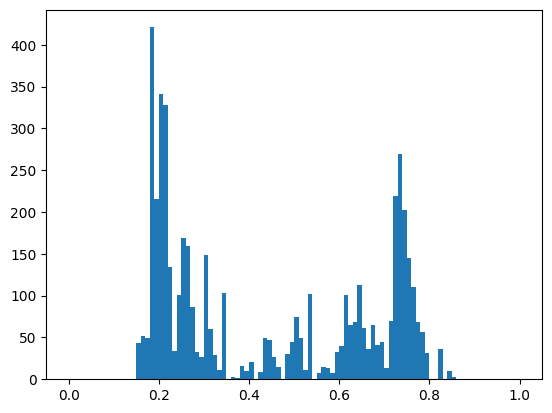

In [11]:
_ = plt.hist(logger.distances, range=(0,1), bins=100)